In [8]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import h5py

from analysis.config import birds, h5_path_dict, pickle_dir
from analysis.ExpData import ExpData
from analysis.utils import get_fr

# Examining mean population FR during caching

### i. Specify parameters to make plots

In [79]:
window = int(20*10)
fr_smoothing_window = int(20*0.5)
l2_normalization = False

### ii. Collect hop-centered activity for each visit

In [80]:
labeled_visits = {}
for key in h5_path_dict.keys():
    for fil in range(len(h5_path_dict[key])):
        fil_string = h5_path_dict[key][fil].as_posix()
        f = h5py.File(fil_string, 'r')
        exp_data = ExpData(f)
        labeled_visits[fil_string] = {}
        cr_visits, noncr_visits = exp_data.get_cr_visits()
        c_visits = cr_visits[exp_data.cache_event]
        r_visits = cr_visits[exp_data.retriev_event]
        hopcentered_visits = exp_data.get_hopcentered_visits(window)
        fr = get_fr(exp_data.spikes, fr_smoothing_window)
        if l2_normalization:
            scaling = np.square(np.linalg.norm(fr, axis=1))
            #scaling = np.linalg.norm(fr, axis=1)
            fr /= scaling[:, None]
        visit_patterns = np.zeros(
            (hopcentered_visits.shape[0], exp_data.num_neurs, window*2 + 1)
            )
        for i, visit in enumerate(hopcentered_visits):
            visit_pattern = fr[:, visit]
            visit_pattern[:, visit == -1] = np.nan
            visit_patterns[i] = visit_pattern            
        labeled_visits[fil_string]['c_visits'] = c_visits
        labeled_visits[fil_string]['r_visits'] = r_visits
        labeled_visits[fil_string]['noncr_visits'] = noncr_visits
        labeled_visits[fil_string]['fr'] = fr
        labeled_visits[fil_string]['visit_patterns'] = visit_patterns
        labeled_visits[fil_string]['visit_times'] = hopcentered_visits

### iii. Plot mean population FR around the hop into a visit

In [81]:
with open(pickle_dir / 'place_cells_1d.p', 'rb') as f: 
    all_place_cells = pickle.load(f)

In [82]:
with open(pickle_dir / 'episode_cells_overlap.p', 'rb') as f: 
    all_ep_cells = pickle.load(f)

In [83]:
frames = np.empty(0)
frames_pl = np.empty(0)
frames_ep = np.empty(0)
mean_frs = np.empty(0)
mean_pl_frs = np.empty(0)
mean_ep_frs = np.empty(0)
visit_types = np.empty(0)
visit_types_pl = np.empty(0)
visit_types_ep = np.empty(0)
for fil_string in labeled_visits.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_visits = labeled_visits[fil_string]['c_visits']
    r_visits = labeled_visits[fil_string]['r_visits']
    noncr_visits = labeled_visits[fil_string]['noncr_visits']
    visit_activity = labeled_visits[fil_string]['visit_patterns']
    pl_sig = all_place_cells[fil_string]['significance']
    ep_sig = all_ep_cells[fil_string]['significance']
    pl_only = np.logical_and(pl_sig, np.logical_not(ep_sig))
    ep_only = np.logical_and(ep_sig, np.logical_not(pl_sig))
    for idx, activity in enumerate(visit_activity):
        num_neurs, num_frames = activity.shape
        mean_fr = np.nanmean(activity, axis=0)
        mean_pl_fr = np.nanmean(activity[pl_only, :], axis=0)
        mean_ep_fr = np.nanmean(activity[ep_only, :], axis=0)
        nonnan_frames = np.argwhere(
            np.logical_not(np.isnan(mean_fr))
            ).squeeze()
        nonnan_pl_frames = np.argwhere(
            np.logical_not(np.isnan(mean_pl_fr))
            ).squeeze()
        nonnan_ep_frames = np.argwhere(
            np.logical_not(np.isnan(mean_ep_fr))
            ).squeeze()
        if idx in c_visits:
            visit_type = ["C"]
        elif idx in r_visits:
            visit_type = ["R"]
        else:
            visit_type = ["N"]
        frames = np.concatenate((frames, nonnan_frames))
        frames_pl = np.concatenate((frames, nonnan_pl_frames))
        frames_ep = np.concatenate((frames, nonnan_ep_frames))
        mean_frs = np.concatenate((mean_frs, mean_fr[nonnan_frames]))
        mean_pl_frs =np.concatenate((mean_pl_frs, mean_pl_fr[nonnan_pl_frames]))
        mean_ep_frs =np.concatenate((mean_ep_frs, mean_ep_fr[nonnan_ep_frames]))
        visit_types = np.concatenate((visit_types, visit_type*nonnan_frames.size))
        visit_types_pl = np.concatenate((visit_types, visit_type*nonnan_pl_frames.size))
        visit_types_ep = np.concatenate((visit_types, visit_type*nonnan_ep_frames.size))

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


Text(0.5, 1.0, 'Mean Population Activity')

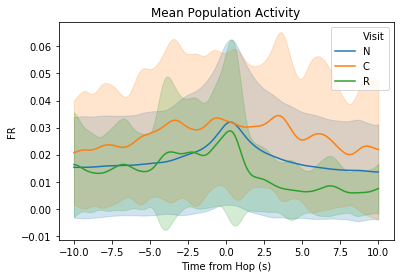

In [84]:
df = pd.DataFrame({
    "Frames": (frames - window)/20, "FR": mean_frs, "Visit": visit_types
    })
sns.lineplot(x="Frames", y="FR", hue="Visit", data=df, ci="sd")
plt.xlabel("Time from Hop (s)")
plt.title("Mean Population Activity")

### iii. Plot mean place-only FR around the hop into a visit

Text(0.5, 1.0, 'Mean Place-Only Population Activity')

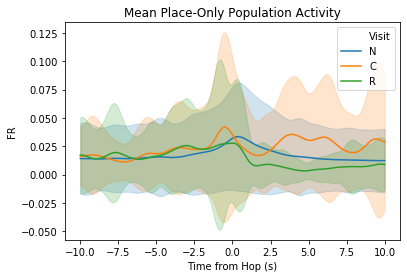

In [85]:
df = pd.DataFrame({
    "Frames": (frames - window)/20, "FR": mean_pl_frs, "Visit": visit_types
    })
sns.lineplot(x="Frames", y="FR", hue="Visit", data=df, ci="sd")
plt.xlabel("Time from Hop (s)")
plt.title("Mean Place-Only Population Activity")

### iii. Plot mean episode-only FR around the hop into a visit

Text(0.5, 1.0, 'Mean Episode-Only Population Activity')

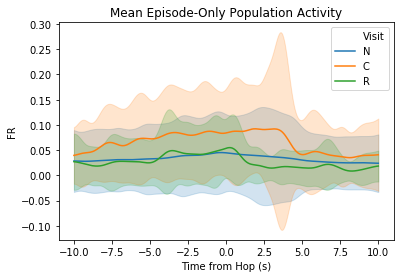

In [86]:
df = pd.DataFrame({
    "Frames": (frames - window)/20, "FR": mean_ep_frs, "Visit": visit_types
    })
sns.lineplot(x="Frames", y="FR", hue="Visit", data=df, ci="sd")
plt.xlabel("Time from Hop (s)")
plt.title("Mean Episode-Only Population Activity")